# Energy Consumption Forecasting with ML in France


**Research Questions**  

To what extent can machine learning models predict daily electricity consumption across French regions, and how do weather and density features improve predictive accuracy?

Which features are most strongly associated with variations in consumption, and how can interpretable ML techniques (e.g., SHAP) be used to understand and communicate these associations?

In [ ]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
# WHY THIS IN THIS PART?

"""
This function plots the predictions versus the true values of the test
data for consumption per capita target. All of these graphs are placed
in the report, so a distinguishing title is given to each during input.
The model is also defined in input, to properly differentiate the results
and compare between models.
"""
def plot_predictions(y_true, y_pred, model_name='Model', figure_number="Figure One"):
    plt.figure(figsize=(10, 6))

    plt.scatter(y_true, y_pred, alpha=0.6)

    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    plt.title(r"$\bf{" + figure_number + r"}$ — Actual vs Predicted — " + model_name, fontsize=20)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#Load the dataset and define the target column, drop NA values from the dataset
cons_filepath = "france_energy_meteo_daily.csv"
cons_target = "Consumption_per_capita"

energy_source_df = pd.read_csv(cons_filepath)
energy_source_df.dropna(inplace=True)
target = cons_target

# Ensure the Date column is in a datetime format
energy_source_df["Date"] = pd.to_datetime(energy_source_df["Date"])

# Place consumption data in the correct unit (kWh) and calculate the consumption per capita
energy_source_df["Consumption"] = energy_source_df["Consumption"] * 1000
energy_source_df[cons_target] = energy_source_df["Consumption"] / energy_source_df["population"]




In [ ]:
"""
Create feature and target variables. Drop categorical variables and highly correlated features
"""
X = energy_source_df.drop(columns=[target, "Date", 'region_name', 'Région', "Consumption", "population", 'NEIG', 'SOLNEIGE'])
y = energy_source_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a K-fold cross-validator instead of TimeSeriesSplit
kfold = KFold(n_splits=2, shuffle=True, random_state=42) #n_splits=5

# For models that need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<>:35: SyntaxWarning: invalid escape sequence '\ '
<>:35: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1575183619.py:35: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_dt, model_name='Decision Tree', figure_number="Figure\ Five")



Decision Tree Regression:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
MAE: 3.2927780508275877
RMSE: 4.2431305548482
R-squared: 0.807875312840547


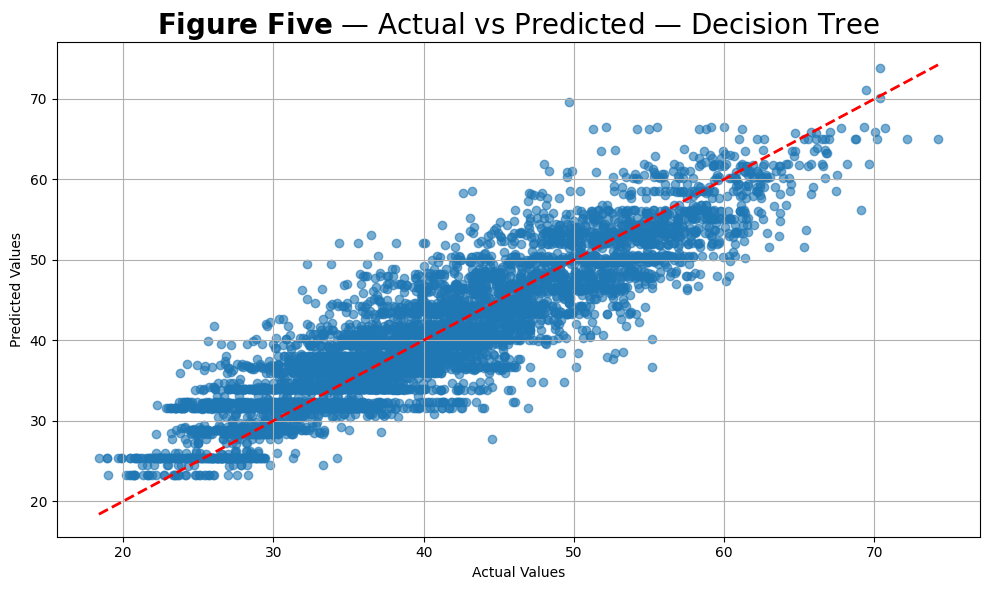

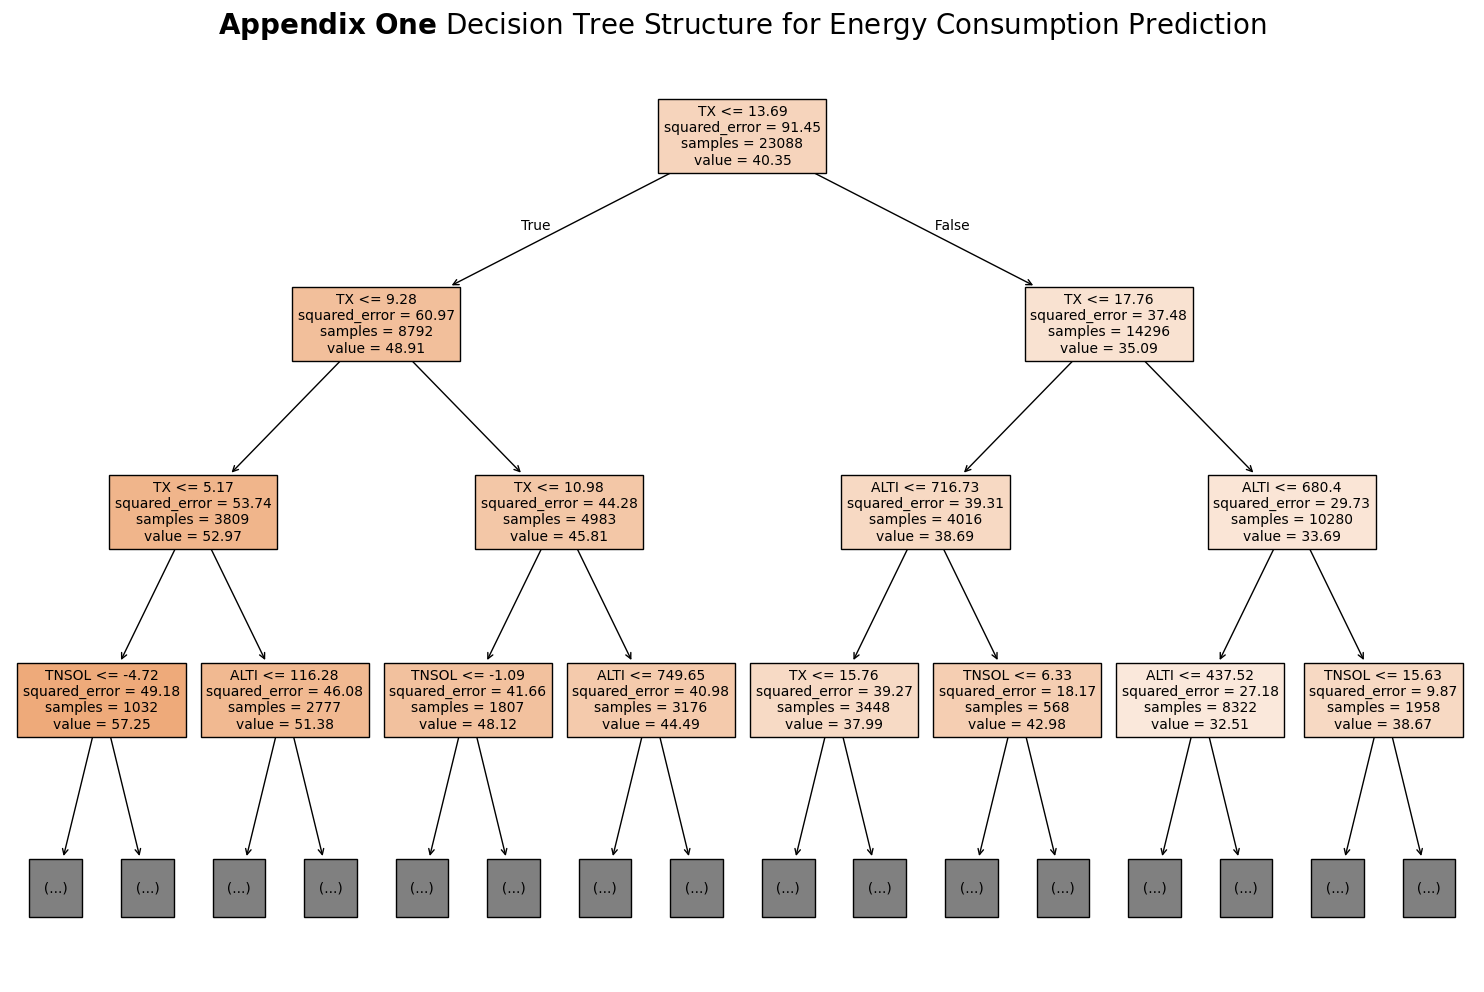

In [ ]:
# (2) Decision Tree

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
dt_params = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit training data and cross validate to find best parameters, Generate from Best Estimator in GridSearch, , Predict
dt_grid.fit(X_train, y_train)
dt_model = dt_grid.best_estimator_
y_pred_dt = dt_model.predict(X_test)


# Evaluation Metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("\nDecision Tree Regression:")
print("Best Parameters:", dt_grid.best_params_)
print("MAE:", mae_dt)
print("RMSE:", rmse_dt)
print("R-squared:", r2_dt)
plot_predictions(y_test, y_pred_dt, model_name='Decision Tree', figure_number="Figure\ Five")

# Print a decision tree to communicate the ease in which a planner could explain the
# prediction from a decision tree. Visual included in the appendix of the report.
plt.figure(figsize=(15, 10))
plot_tree(dt_model,
          feature_names=X.columns,
          filled=True,
          proportion=False,
          precision=2,
          impurity=True,
          max_depth=3,
          fontsize=10,
          node_ids=False,)
plt.title(r"$\bf{Appendix\ One}$ Decision Tree Structure for Energy Consumption Prediction", fontsize=20)
plt.tight_layout(pad=1.0)
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-103260272.py:36: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_rf, model_name='Random Forest', figure_number="Figure\ Four")



Random Forest Regression:
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 2.8399064053904244
RMSE: 3.6272126780844385
R-squared: 0.8596034532902412


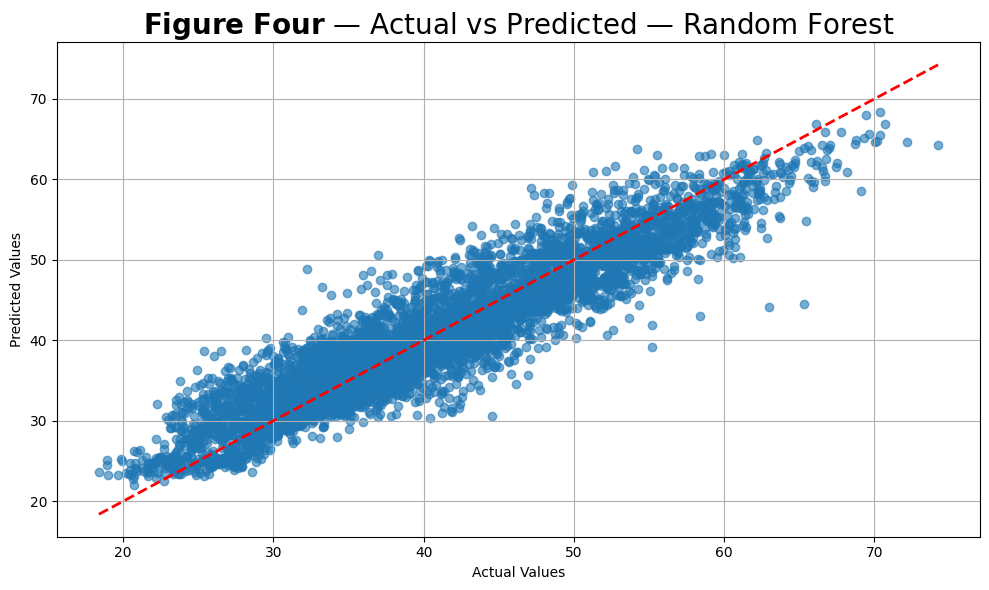

In [ ]:
# (3) Random Forests

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
rf_params = {
    'n_estimators': [100, 200], #300
    'max_depth': [10, 30], #None, 50
    'min_samples_split': [2, 5], #10
    'min_samples_leaf': [1, 2] #4
    }

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)


# Fit training data and cross validate to find best parameters, Generate from Best Estimator in GridSearch, , Predict
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression:")
print("Best Parameters:", rf_grid.best_params_)
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R-squared:", r2_rf)
plot_predictions(y_test, y_pred_rf, model_name='Random Forest', figure_number="Figure\ Four")

<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:33: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1056758878.py:33: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_svr_linear, model_name='SVR Linear', figure_number="Appendix\ Three")



SVR (Linear):
Best Parameters: {'C': 10.0, 'epsilon': 0.001}
MAE: 4.89825829547545
RMSE: 6.054111932589013
R-squared: 0.6088788721023701


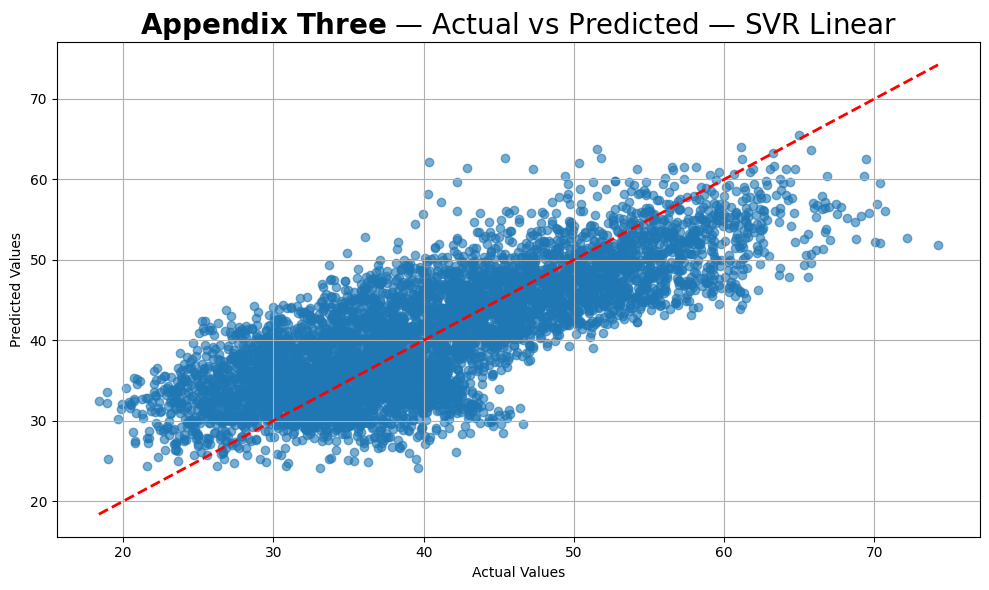

In [ ]:
# (4) Support Vector Machines - Linear Function

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
svr_linear_params = {
    'C': [1.0, 10.0], #, 100.0, 1000.0
    'epsilon': [0.001, 0.01] #, 0.1
}

svr_linear_grid = GridSearchCV(
    SVR(kernel='linear'),
    svr_linear_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit and cross validate with scaled training, Generate from Best Estimator in GridSearch, Predict to scaled test
svr_linear_grid.fit(X_train_scaled, y_train)
svr_linear_model = svr_linear_grid.best_estimator_
y_pred_svr_linear = svr_linear_model.predict(X_test_scaled)

# Evaluation Metrics
mae_svr_linear = mean_absolute_error(y_test, y_pred_svr_linear)
rmse_svr_linear = np.sqrt(mean_squared_error(y_test, y_pred_svr_linear))
r2_svr_linear = r2_score(y_test, y_pred_svr_linear)

print("\nSVR (Linear):")
print("Best Parameters:", svr_linear_grid.best_params_)
print("MAE:", mae_svr_linear)
print("RMSE:", rmse_svr_linear)
print("R-squared:", r2_svr_linear)
plot_predictions(y_test, y_pred_svr_linear, model_name='SVR Linear', figure_number="Appendix\ Three")

<>:34: SyntaxWarning: invalid escape sequence '\ '
<>:34: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2667293759.py:34: SyntaxWarning: invalid escape sequence '\ '
  plot_predictions(y_test, y_pred_svr_rbf, model_name='SVR RBF', figure_number="Appendix\ Four")



SVR (RBF):
Best Parameters: {'C': 1.0, 'epsilon': 0.2, 'gamma': 'auto'}
MAE: 4.07622983922079
RMSE: 5.104590398417949
R-squared: 0.7219440564712838


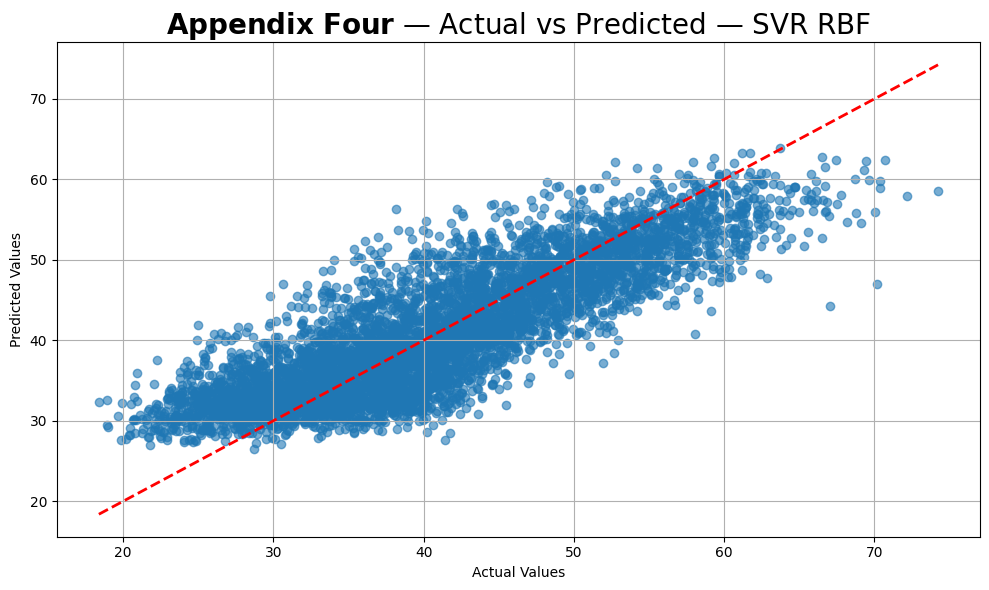

In [ ]:
# (5) Support Vector Machines - Radial Base Function

# Perform a GridSearchCV that performs cross validation and tuning at the same time. Necessary to
# establish the best performing model for model comparison.
svr_rbf_params = {
    'C': [0.1, 1.0],#, 10.0, 100.0
    'gamma': ['auto', 0.1],#'scale', , 0.01
    'epsilon': [0.1, 0.2]#, 0.3
}

svr_rbf_grid = GridSearchCV(
    SVR(kernel='rbf'),
    svr_rbf_params,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit and cross validate with scaled training, Generate from Best Estimator in GridSearch, Predict to scaled test
svr_rbf_grid.fit(X_train_scaled, y_train)
svr_rbf_model = svr_rbf_grid.best_estimator_
y_pred_svr_rbf = svr_rbf_model.predict(X_test_scaled)

# Evaluation Metrics
mae_svr_rbf = mean_absolute_error(y_test, y_pred_svr_rbf)
rmse_svr_rbf = np.sqrt(mean_squared_error(y_test, y_pred_svr_rbf))
r2_svr_rbf = r2_score(y_test, y_pred_svr_rbf)

print("\nSVR (RBF):")
print("Best Parameters:", svr_rbf_grid.best_params_)
print("MAE:", mae_svr_rbf)
print("RMSE:", rmse_svr_rbf)
print("R-squared:", r2_svr_rbf)
plot_predictions(y_test, y_pred_svr_rbf, model_name='SVR RBF', figure_number="Appendix\ Four")